# K-Nearest Neighbours (KNN)

K-Neighbours is a **supervised classification algorithm**. Classification is the process of assigning samples into those groups. Given a set of groups, take a set of samples and mark each sample as being a member of a group. Each group being the correct answer, label, or classification of the sample.

The K-Nearest Neighbours - or KNN - classifier, is one of the simplest machine learning algorithms.

K-Nearest Neighbours works by first simply storing all of your training data samples.
Then in the future, when you attempt to check the classification of a new, never-before seen sample, it finds the nearest "K" number of samples to it from within your training data. You must have numeric features in order for 'nearest' to be meaningful.  
SciKit-Learn's K-Nearest Neighbours only supports numeric features, so you'll have to do whatever has to be done to get your data into that format before proceeding. The distance will be measures as a standard Euclidean.

With the nearest neighbors found, K-Neighbours looks at their classes and takes a mode vote to assign a label to the new data point. Further extensions of K-Neighbours can take into account the distance to the samples to weigh their voting power.   
Each new prediction or classification made, the algorithm has to again find the nearest neighbors to that sample in order to call a vote for it. This process is where a majority of the time is spent, so instead of using brute force to search the training data as if it were stored in a list, tree structures are used instead to optimize the search times. Due to this, the number of classes in dataset doesn't have a bearing on its execution speed. Only the number of records in your training data set.

#  A wheat example

Yes, always the same example :D  
  
We do the usual data reading and pre-processing, concluding with normalisation and splitting the data into test and training datasets.

## Read the data

In [1]:
import pandas as pd

In [2]:
#
# Load up the dataset into a variable called X.
#
X = pd.read_csv("/content/wheat.data", index_col='id')
X.head()


,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
id,,,,,,,,
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,kama


## Data pre-processing

First we separate the target variable

In [3]:
#
# Copy the 'wheat_type' series slice out of X, and into a series
# called 'y'. Then drop the original 'wheat_type' column from the X
#
y = X.wheat_type.copy()
X.drop(['wheat_type'], axis=1, inplace=True)

In [4]:
y_original = y

In [5]:
# Do a quick, "ordinal" conversion of 'y'.
#
y = y.astype("category").cat.codes

Fix the invalid values

In [6]:
#
# Basic nan munging. Fill each row's nans with the mean of the feature
#
X.fillna(X.mean(), inplace=True)

Split the data into training and testing datasets

In [7]:
from sklearn.model_selection import train_test_split

#
# Split X into training and testing data sets
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=1)

## Data normalisation

In [8]:
from sklearn import preprocessing

#
# Create an instance of SKLearn's Normalizer class and then train it
# using its .fit() method against the *training* data.
#
#
normaliser = preprocessing.Normalizer().fit(X_train)

In [9]:
#
# With the trained pre-processor, transform both training AND
# testing data.
#
# NOTE: Any testing data has to be transformed with the preprocessor
# that has been fit against the training data, so that it exist in the same
# feature-space as the original data used to train the models.
#
X_train_normalised = normaliser.transform(X_train)
X_train = pd.DataFrame(X_train_normalised)

X_test_normalised = normaliser.transform(X_test)
X_test = pd.DataFrame(X_test_normalised)

## Apply PCA

Finally apply a PCA transformation.  

This has to be done because the only way to visualise the decision boundary in 2D would be if the KNN algorithm ran in 2D as well.  
Note that removing the PCA will improve the accuracy (KNeighbours is applied to the entire train data, not just the two principal components).

In [10]:
from sklearn.decomposition import PCA

#
# Just like the preprocessing transformation, create a PCA
# transformation as well. Fit it against the training data, and then
# project the training and testing features into PCA space using the
# PCA model's .transform() method.
#
#

pca_reducer = PCA(n_components=2).fit(X_train_normalised)

X_train_pca = pca_reducer.transform(X_train_normalised)
X_test_pca = pca_reducer.transform(X_test_normalised)

## KNN algorithm

Now we finally apply the K-neighbours algorithm, using the related module from SKlearn.

For K-Neighbours, generally **the higher your "K" value, the smoother and less jittery your decision surface becomes**. Higher K values also result in your model providing probabilistic information about the ratio of samples per each class. There is a tradeoff though, as higher K values mean the algorithm is less sensitive to local fluctuations since farther samples are taken into account. This causes it to only model the overall classification function without much attention to detail, and increases the computational complexity of the classification.

We use here K = 9

In [11]:
from sklearn.neighbors import KNeighborsClassifier

#
# Create and train a KNeighborsClassifier. Start with K=9 neighbors.
# NOTE: Be sure to train the classifier against the pre-processed, PCA-
# transformed training data above!
#
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=9)

## Decision Boundaries
A unique feature of supervised classification algorithms are their decision boundaries, or more generally, their n-dimensional decision surface: a threshold or region where if superseded, will result in your sample being assigned that class.

The decision surface isn't always spherical. In fact, it can take many different types of shapes depending on the algorithm that generated it.


Let's prepare a function to plot the decision boundaries, that we can use for other examples, later

In [12]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty


In [13]:
import numpy as np


In [14]:
def plotDecisionBoundary(model, X, y, colors, padding=0.6, resolution = 0.0025):

  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)


  # Calculate the boundaries
  x_min, x_max = X[:, 0].min(), X[:, 0].max()
  y_min, y_max = X[:, 1].min(), X[:, 1].max()
  x_range = x_max - x_min
  y_range = y_max - y_min
  x_min -= x_range * padding
  y_min -= y_range * padding
  x_max += x_range * padding
  y_max += y_range * padding


  # Create a 2D Grid Matrix. The values stored in the matrix
  # are the predictions of the class at at said location
  xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                       np.arange(y_min, y_max, resolution))

  # What class does the classifier say?
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # Plot the contour map using the rainbow colourmap
  #cs = plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow)
  ax.contourf(xx, yy, Z, cmap=plt.cm.rainbow)
  fig.tight_layout(pad=2)

  # Plot the testing original points as well...
  for label in np.unique(y):
    indices = np.where(y == label)
    ax.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

  # print the title
  p = model.get_params()
  fig.suptitle('Decision boundaries, K = ' + str(p['n_neighbors']))

Just a reminder: these are the wheat labels:

In [15]:
for label in np.unique(y_original):
    print (label)

canadian
kama
rosa


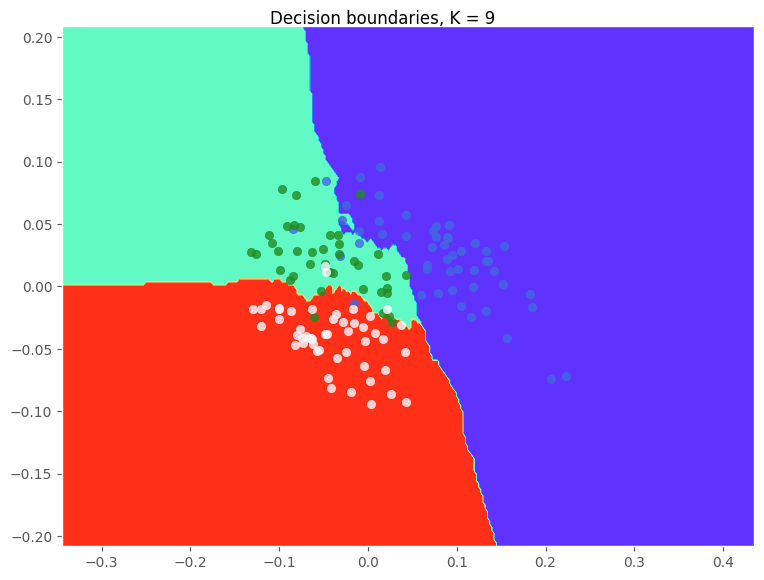

In [16]:
myColours = ['royalblue','forestgreen','ghostwhite']

plotDecisionBoundary(knn, X_train_pca, y_train, colors =  myColours)

The KNN (with K=9) algorithm divided the space into three clusters, one for each wheat type.  
The clusters fit quite well the testing data but not perfectly, some data points are mis-classified.

In [17]:
#
# Display the accuracy score of the test data/labels, computed by
# the KNeighbors model.
#
# NOTE: You do NOT have to run .predict before calling .score, since
# .score will take care of running the predictions automatically.
#
print(knn.score(X_test_pca, y_test))


0.8714285714285714



K-Neighbours is particularly useful when no other model fits your data well, as it is **a parameter free** approach to classification. So for example, you don't have to worry about things like your data being linearly separable or not.

Some of the caution-points to keep in mind while using K-Neighbours is that your data needs to be measurable. If there is no metric for discerning distance between your features, K-Neighbours cannot help you. As with all algorithms dependent on distance measures, it is also sensitive to feature scaling, to perturbations and the local structure of your dataset, particularly at lower "K" values.

# KNN with hyper-parameters

We now explore deeper how the algorithm's parameters impact it, using as an example a dataset to classify a breast tumor as benign or malign.  

Breast cancer doesn't develop over night and, like any other cancer, can be treated extremely effectively if detected in its earlier stages. Part of the understanding cancer is knowing that not all irregular cell growths are malignant; some are benign, or non-dangerous, non-cancerous growths.   
Being able to properly assess if a tumor is actually benign and ignorable, or malignant and alarming is therefore of importance, and also is a problem that might be solvable through data and machine learning.
Using the Breast Cancer Wisconsin Original data set, provided courtesy of [UCI's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original))

## Read the data


In [18]:
#
# Load in the dataset, identify nans, and set proper headers.
#
X = pd.read_csv("../Datasets/breast-cancer-wisconsin.data", header=None,
                 names=['sample', 'thickness', 'size', 'shape', 'adhesion',
                        'epithelial', 'nuclei', 'chromatin', 'nucleoli',
                        'mitoses', 'status'], index_col='sample', na_values='?')


FileNotFoundError: ignored

In [ ]:
X.head()

## Data Pre-processing

Extract the target values, remove all NaN values and split into testing and training data

In [ ]:
#
# Copy out the status column into a slice, then drop it from the main
# dataframe.
#
#
y = X.status.copy()
X.drop(['status'], axis=1, inplace=True)

In [ ]:
#
# With the labels safely extracted from the dataset, replace any nan values
# with the mean feature / column value
#
if X.isnull().values.any() == True:
  print("Preprocessing data: substituted all NaN with mean value")
  X.fillna(X.mean(), inplace=True)
else:
  print("Preprocessing data: No NaN found!")

In [ ]:
#
# Do train_test_split. set the random_state=7 for reproduceability, and keep
# the test_size at 0.5 (50%).
#
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5, random_state=7)


## Define hyper-parameters.

We will loop the KNN algorithm with different parameters, specifically:  

- different scalers for normalisation
- reduced or not reduced (here PCA but can also use isomap for reduction)
- different weight function
- and different values of K

In [ ]:
# automate the tuning of hyper-parameters using for-loops to traverse the search space.
reducers = [False, True]
weights = ['uniform', 'distance']

# Experiment with the basic SKLearn preprocessing scalers. We know that
# the features consist of different units mixed in together, so it might be
# reasonable to assume feature scaling is necessary.
scalers = [preprocessing.Normalizer, preprocessing.StandardScaler,
           preprocessing.MinMaxScaler, preprocessing.RobustScaler]


In [ ]:
from sklearn.decomposition import PCA
from sklearn import manifold


## Hyper-parameters tuning
Loop through all the parameters: fit the model and print the result every time

In [ ]:
# the f print function works from Python 3.6, you can use print otherwise
separator = "--------------------------------------"
print('*** Starting K-neighbours classifier')
print(separator)

bestScore = 0.0

# outer loop: the scalers
for scaler in scalers:
  print("* Scaler = ", scaler)

  scalerTrained = scaler().fit(X_train)

  X_train_scaled = scalerTrained.transform(X_train)
  X_test_scaled  = scalerTrained.transform(X_test)


  print("PCA?  | K  | Weight | Score")
  print(separator)

  # next loop though PCA reduction or not

  reducer = None

  for isPCA in reducers:
    if isPCA:
    #
    # Implement PCA here: reduce down to two dimensions.
    #
      reducer = PCA(n_components=2).fit(X_train_scaled)

    else:
    #
    # Implement Isomap here.  K values can be from 5 to 10.
    # Reduce down to two dimensions.
    #
      reducer = manifold.Isomap(n_neighbors=10, n_components=2).fit(X_train_scaled)

    # 2D transformation on both datasets
    X_train_reduced = reducer.transform(X_train_scaled)
    X_test_reduced  = reducer.transform(X_test_scaled)

    #
    # Implement and train KNeighborsClassifier on the projected 2D
    # training data. You can use any K value from 1 - 15, so play around
    # with it and see what results you can come up. Your goal is to find a
    # good balance where you aren't too specific (low-K), nor are you too
    # general (high-K). You should also experiment with how changing the weights
    # parameter affects the results.
    #
    for k in range(1,16):
        for weight in weights:

            #
            # Train the model against data_train.
            #
            knmodel = KNeighborsClassifier(n_neighbors = k, weights = weight)
            knmodel.fit(X_train_reduced, y_train)


# INFO: Be sure to always keep the domain of the problem in mind! It's
# WAY more important to errantly classify a benign tumor as malignant,
# and have it removed, than to incorrectly leave a malignant tumor, believing
# it to be benign, and then having the patient progress in cancer. Since the UDF
# weights don't give you any class information, the only way to introduce this
# data into SKLearn's KNN Classifier is by "baking" it into your data. For
# example, randomly reducing the ratio of benign samples compared to malignant
# samples from the training set.

#
# Calculate + Print the accuracy of the testing set
#
            currentScore = knmodel.score(X_test_reduced, y_test)

            print(f"{isPCA} | {k} | {weight} | {currentScore}")

            # save the best model for plotting it later
            if (currentScore > bestScore):
                bestScore = currentScore
                bestPCA = isPCA
                bestK = k
                bestWeight = weight
                bestScaler = scaler

## Re-apply the best parameters to the model

In [ ]:
print("These are the best parameters for the model:")
print("PCA?  | K  | Weight | Scaler | Score")
print(f"{bestPCA}  | {bestK} | {bestWeight} | {bestScaler} | {bestScore}")

In [ ]:
BestScalerTrained = bestScaler().fit(X_train)

X_train_scaled = BestScalerTrained.transform(X_train)
X_test_scaled  = BestScalerTrained.transform(X_test)


if isPCA:
    #
    # Implement PCA here.
    # You should reduce down to two dimensions.
    #
    reducer = PCA(n_components=2).fit(X_train_scaled)

else:
    #
    # Implement Isomap here.  K values from 5-10.
    # You should reduce down to two dimensions.
    #
    reducer = manifold.Isomap(n_neighbors=10, n_components=2).fit(X_train_scaled)

    #
    # Train your model against data_train, then transform both
    # data_train and data_test using your model. You can save the results right
    # back into the variables themselves.
    #
X_train_reduced = reducer.transform(X_train_scaled)
X_test_reduced  = reducer.transform(X_test_scaled)

    #
    # Implement and train KNeighborsClassifier on your projected 2D
    # training data here. You can use any K value from 1 - 15, so play around
    # with it and see what results you can come up. Your goal is to find a
    # good balance where you aren't too specific (low-K), nor are you too
    # general (high-K). You should also experiment with how changing the weights
    # parameter affects the results.
    #
bestKnmodel = KNeighborsClassifier(n_neighbors = bestK, weights = bestWeight)
bestKnmodel.fit(X_train_reduced, y_train)

## Plotting the decision boundaries

In [ ]:
# 2 for benign (blue colour), 4 for malignant (red colour)
myColours = {2:'royalblue',4:'lightsalmon'}

plotDecisionBoundary(bestKnmodel, X_test_reduced, y_test, colors =  myColours, padding = 0.1, resolution = 0.1)

# Another example for KNN with reduction

In [ ]:
import scipy.io
import math

# Same datasets as in the PCA example!
# load up the face_data.mat, calculate the
# num_pixels value, and rotate the images to being right-side-up
# instead of sideways.
#
mat = scipy.io.loadmat('../datasets/face_data.mat')
df = pd.DataFrame(mat['images']).T
num_images, num_pixels = df.shape
num_pixels = int(math.sqrt(num_pixels))

# Rotate the pictures, so we don't have to crane our necks:
for i in range(num_images):
  df.loc[i,:] = df.loc[i,:].values.reshape(num_pixels, num_pixels).T.reshape(-1)


In [ ]:
#
# Load up the face_labels dataset. It only has a single column, and
# we're only interested in that single column. We have to slice the
# column out so that we have access to it as a "Series" rather than as a
# "Dataframe".
#
labelsDF = pd.read_csv("../Datasets/face_labels.csv", header=None)
labels = labelsDF.iloc[:,0]

In [ ]:
#
# Do train_test_split. The labels are actually passed in as a series
# (instead of as an NDArray) to access their underlying indices
# later on. This is necessary to find the samples in the original
# dataframe, which is used to plot the testing data as images rather
# than as points:
#
data_train, data_test, label_train, label_test = train_test_split(df, labels,
                                            test_size=0.15, random_state=7)

In [ ]:
# If you'd like to try with PCA instead of Isomap,
# as the dimensionality reduction technique:
Test_PCA = False

In [ ]:
if Test_PCA:
  # INFO: PCA is used *before* KNeighbors to simplify the high dimensionality
  # image samples down to just 2 principal components! A lot of information
  # (variance) is lost during the process, as I'm sure you can imagine. But
  # you have to drop the dimension down to two, otherwise you wouldn't be able
  # to visualize a 2D decision surface / boundary. In the wild, you'd probably
  # leave in a lot more dimensions, but wouldn't need to plot the boundary;
  # simply checking the results would suffice.
  #
  # The model should only be trained (fit) against the training data (data_train)
  # Once we've done this, we use the model to transform both data_train
  # and data_test from their original high-D image feature space, down to 2D
  # Finally, storing the results back into
  # data_train and data_test.

  pca_reducer = PCA(n_components=2).fit(data_train)

  data_train = pca_reducer.transform(data_train)
  data_test  = pca_reducer.transform(data_test)

else:

  # INFO: Isomap is used *before* KNeighbors to simplify the high dimensionality
  # image samples down to just 2 components! A lot of information has been is
  # lost during the process, as I'm sure you can imagine. But if you have
  # non-linear data that can be represented on a 2D manifold, you probably will
  # be left with a far superior dataset to use for classification. Plus by
  # having the images in 2D space, you can plot them as well as visualize a 2D
  # decision surface / boundary. In the wild, you'd probably leave in a lot
  # more dimensions, but wouldn't need to plot the boundary; simply checking
  # the results would suffice.
  #
  # The model should only be trained (fit) against the training data (data_train)
  # Once done this, we use the model to transform both data_train
  # and data_test from their original high-D image feature space, down to 2D
  # storing the results back into
  # data_train, and data_test.

  iso_reducer = manifold.Isomap(n_neighbors=5, n_components=2).fit(data_train)
  data_train = iso_reducer.transform(data_train)
  data_test  = iso_reducer.transform(data_test)


In [ ]:
#
# Implement KNeighborsClassifier.
#
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, label_train)

In [ ]:
#
# Calculate + Print the accuracy of the testing set (data_test and
# label_test).
#
#
print(knn.score(data_test, label_test))

# isomap: 0.961904761905
# pca: 0.571428571429

In [ ]:
matplotlib.style.use('ggplot') # Look Pretty


def Plot2DBoundary(model, DTrain, LTrain, DTest, LTest):
  # The dots are training samples (img not drawn), and the pics are testing samples (images drawn)
  # Play around with the K values. This is very controlled dataset so it
  # should be able to get perfect classification on testing entries

  fig = plt.figure(figsize=(9,8))
  ax = fig.add_subplot(111)
  ax.set_title('Transformed Boundary, Image Space -> 2D')

  padding = 0.1   # Zoom out
  resolution = 1  # Don't get too detailed; smaller values (finer rez) will take longer to compute
  colors = ['blue','green','orange','red']


  # ------

  # Calculate the boundaries of the mesh grid. The mesh grid is
  # a standard grid (think graph paper), where each point will be
  # sent to the classifier (KNeighbors) to predict what class it
  # belongs to. This is why KNeighbors has to be trained against
  # 2D data, so we can produce this countour. Once we have the
  # label for each point on the grid, we can color it appropriately
  # and plot it.
  x_min, x_max = DTrain[:, 0].min(), DTrain[:, 0].max()
  y_min, y_max = DTrain[:, 1].min(), DTrain[:, 1].max()
  x_range = x_max - x_min
  y_range = y_max - y_min
  x_min -= x_range * padding
  y_min -= y_range * padding
  x_max += x_range * padding
  y_max += y_range * padding

  # Using the boundaries, actually make the 2D Grid Matrix:
  xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                       np.arange(y_min, y_max, resolution))

  # What class does the classifier say about each spot on the chart?
  # The values stored in the matrix are the predictions of the model
  # at said location:
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # Plot the mesh grid as a filled contour plot:
  ax.contourf(xx, yy, Z, cmap=plt.cm.terrain)


  # ------

  # When plotting the testing images, used to validate if the algorithm
  # is functioning correctly, size them as 5% of the overall chart size
  x_size = x_range * 0.05
  y_size = y_range * 0.05

  # First, plot the images in the TEST dataset
  img_num = 0
  for index in LTest.index:
    # DTest is a regular NDArray, so you'll iterate over that 1 at a time.
    x0, y0 = DTest[img_num,0]-x_size/2., DTest[img_num,1]-y_size/2.
    x1, y1 = DTest[img_num,0]+x_size/2., DTest[img_num,1]+y_size/2.

    # DTest = our images isomap-transformed into 2D. But we still want
    # to plot the original image, so we look to the original, untouched
    # dataset (at index) to get the pixels:
    img = df.iloc[index,:].values.reshape(num_pixels, num_pixels)
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1), alpha=0.8)
    img_num += 1


  # Plot the TRAINING points as well... as points rather than as images
  for label in range(len(np.unique(LTrain))):
    indices = np.where(LTrain == label)
    ax.scatter(DTrain[indices, 0], DTrain[indices, 1], c=colors[label], alpha=0.8, marker='o')


In [ ]:
# Chart the combined decision boundary, the training data as 2D plots, and
# the testing data as small images so we can visually validate performance.
Plot2DBoundary(knn, data_train, label_train, data_test, label_test)


That's all for KNN!